# Processing USDA data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm

%matplotlib inline
plt.rcParams.update({'font.size': 24})

### USDA: add state trends to county data

In [2]:
# Load USDA data
usda_county = pd.read_csv("./usda_grab/output/USDA_county_yields.csv").drop_duplicates(subset = ["GEOID", "year"], keep = "first")
usda_state = pd.read_csv("./usda_grab/output/USDA_state_yields.csv")
usda_state = usda_state.rename(columns = {"Value" : "state_Value", "lowess_log_Value" : "lowess_log_state_Value"})

In [3]:
# Add logs
usda_county["Log_value"] = usda_county.apply(lambda x: np.log(x["Value"]) if x["Value"] > 0.0 else 0.0, axis = 1)

In [4]:
# Merge
usda_final = pd.merge(usda_county, usda_state.drop(columns = ["state_alpha", "Area", "log_Value"]), on = ["state_fips_code", "year"], how = "inner", copy = False)
usda_final["GEOID"] = usda_final["GEOID"].astype(str).str[:-2].str.zfill(5)

In [5]:
usda_final.head()

,GEOID,year,state_fips_code,county_code,asd_code,Value,area,Log_value,state_Value,lowess_log_state_Value,quad_fit
0,100140,1950,1,1.0,40,17.0,29600.0,2.833213,21.5,3.033747,2.930451
1,101140,1950,1,11.0,40,11.0,24200.0,2.397895,21.5,3.033747,2.930451
2,104740,1950,1,47.0,40,13.0,44200.0,2.564949,21.5,3.033747,2.930451
3,105140,1950,1,51.0,40,23.0,38900.0,3.135494,21.5,3.033747,2.930451
4,106340,1950,1,63.0,40,16.0,23900.0,2.772589,21.5,3.033747,2.930451


In [6]:
# Get differences
usda_final["target_Value"] = usda_final["Log_value"] - usda_final["quad_fit"]

In [7]:
# Add log state value
usda_final["log_state_Value"] = usda_final.apply(lambda x: np.log(x["state_Value"]) if x["state_Value"] > 0.0 else 0.0, axis = 1)

In [8]:
usda_final.head()

,GEOID,year,state_fips_code,county_code,asd_code,Value,area,Log_value,state_Value,lowess_log_state_Value,quad_fit,target_Value,log_state_Value
0,100140,1950,1,1.0,40,17.0,29600.0,2.833213,21.5,3.033747,2.930451,-0.097238,3.068053
1,101140,1950,1,11.0,40,11.0,24200.0,2.397895,21.5,3.033747,2.930451,-0.532556,3.068053
2,104740,1950,1,47.0,40,13.0,44200.0,2.564949,21.5,3.033747,2.930451,-0.365502,3.068053
3,105140,1950,1,51.0,40,23.0,38900.0,3.135494,21.5,3.033747,2.930451,0.205043,3.068053
4,106340,1950,1,63.0,40,16.0,23900.0,2.772589,21.5,3.033747,2.930451,-0.157862,3.068053


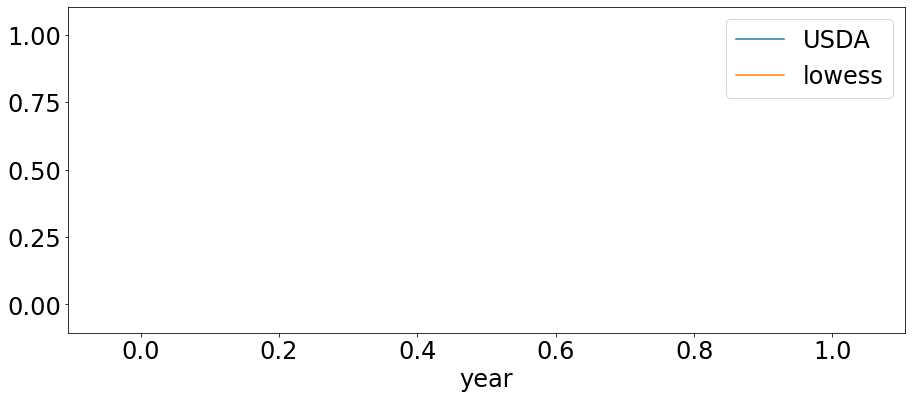

In [9]:
# Testing
fig, ax = plt.subplots(figsize = (15,6))
usda_final.query("GEOID == '01007'").reset_index().plot(x = "year", y = "Log_value", ax = ax, label = "USDA")
usda_final.query("GEOID == '01007'").reset_index().plot(x = "year", y = "quad_fit", ax = ax, label = "lowess")
plt.legend()
plt.show()

In [16]:
# Save
usda_final.query("Value > 0.0").to_csv("./final/USDA_county_yields_w_quad_state_trends.csv", index = False)

### USDA: add county trends to county data

In [10]:
# Load USDA data
usda_county = pd.read_csv("./usda_grab/output/USDA_county_yields.csv").drop_duplicates(subset = ["GEOID", "year"], keep = "first")
usda_county["GEOID"] = usda_county["GEOID"].astype(str)
usda_county.set_index(["GEOID"], inplace= True)

In [11]:
# Add logs
usda_county["log_Value"] = usda_county.apply(lambda x: np.log(x["Value"]) if x["Value"] > 0.0 else np.nan, axis = 1)

In [12]:
# Do lowess filter
lowess = sm.nonparametric.lowess
usda_county = usda_county.query("Value > 0.0")
usda_county["lowess_log_Value"] = 0.0
usda_county['quad_fit'] = 0.0
usda_county['quad_fit_nolog'] = 0.0

for geoid in usda_county.index.unique(level = "GEOID"):

    data = usda_county.loc[geoid]
    
    if type(data["Value"]) != np.float64:
        lws_filter = lowess(data["log_Value"], data["year"], missing = "drop", frac = 0.5)
        z = np.polyfit(data['year'], data['log_Value'], 2)
        p = np.poly1d(z)
        
        zn = np.polyfit(data['year'], data['Value'], 2)
        pn = np.poly1d(zn)
    
        temp = pd.DataFrame(data = {"lowess_log_Value_x" : pd.Series(lws_filter[:,1], index = pd.MultiIndex.from_arrays([[geoid]*len(lws_filter[:,0].astype(int)), lws_filter[:,0].astype(int)]))})
        tempQ = pd.DataFrame(data = {"quad_fit_x" : pd.Series(p(data['year']), index = pd.MultiIndex.from_arrays([[geoid]*len(data['year'].astype(int)), data['year'].astype(int)]))})
        tempQnl = pd.DataFrame(data = {"quad_fit_y" : pd.Series(pn(data['year']), index = pd.MultiIndex.from_arrays([[geoid]*len(data['year'].astype(int)), data['year'].astype(int)]))})
        temp.index.names = ["GEOID", "year"]
        tempQ.index.names = ["GEOID", "year"]
        tempQnl.index.names = ["GEOID", "year"]
        usda_county = pd.merge(usda_county, temp, on = ["GEOID", "year"], how = "outer")
        usda_county = pd.merge(usda_county, tempQ, on = ["GEOID", "year"], how = "outer")
        usda_county = pd.merge(usda_county, tempQnl, on = ["GEOID", "year"], how = "outer")
        usda_county = usda_county.fillna(0)
        usda_county["lowess_log_Value"] = usda_county["lowess_log_Value"] + usda_county["lowess_log_Value_x"]
        usda_county["quad_fit"] = usda_county["quad_fit"] + usda_county["quad_fit_x"]
        usda_county["quad_fit_nolog"] = usda_county["quad_fit_nolog"] + usda_county["quad_fit_y"]
        del usda_county["lowess_log_Value_x"]
        del usda_county["quad_fit_x"]
        del usda_county["quad_fit_y"]

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/davidlaf

KeyboardInterrupt: 

In [5]:
# Get differences
usda_county["target_Value"] = usda_county["log_Value"] - usda_county["lowess_log_Value"]
usda_county["target_ValueQ"] = usda_county["log_Value"] - usda_county["quad_fit"]  
usda_county["target_ValueQnl"] = usda_county["Value"] - usda_county["quad_fit_nolog"]

In [6]:
usda_county.head()

,year,state_fips_code,county_code,asd_code,Value,area,log_Value,lowess_log_Value,quad_fit,quad_fit_nolog,target_Value,target_ValueQ,target_ValueQnl
GEOID,,,,,,,,,,,,,
100140,1950,1,1,40,17.0,29600.0,2.833213,2.781382,2.989864,30.189037,0.051832,-0.156651,-13.189037
101140,1950,1,11,40,11.0,24200.0,2.397895,2.577520,2.692456,22.742437,-0.179625,-0.294560,-11.742437
104740,1950,1,47,40,13.0,44200.0,2.564949,2.582856,2.688544,19.847891,-0.017906,-0.123594,-6.847891
105140,1950,1,51,40,23.0,38900.0,3.135494,3.019246,2.996067,30.030629,0.116248,0.139427,-7.030629
106340,1950,1,63,40,16.0,23900.0,2.772589,2.586292,2.654366,23.005317,0.186296,0.118223,-7.005317


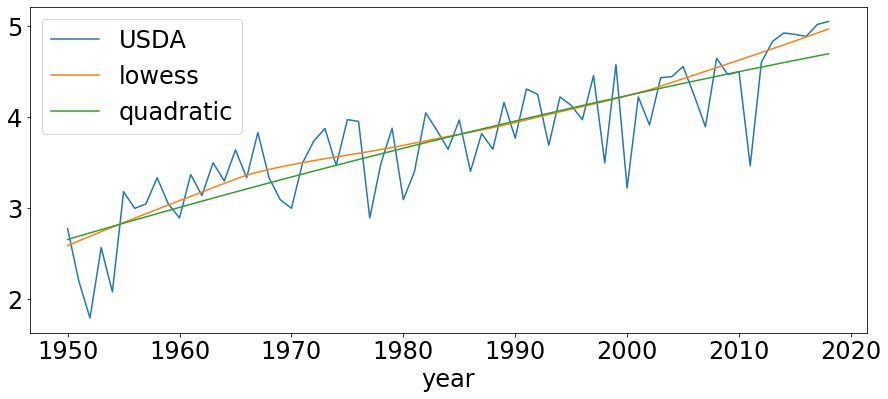

In [7]:
# Testing
fig, ax = plt.subplots(figsize = (15,6))
usda_county.query("GEOID == '106340'").reset_index().plot(x = "year", y = "log_Value", ax = ax, label = "USDA")
usda_county.query("GEOID == '106340'").reset_index().plot(x = "year", y = "lowess_log_Value", ax = ax, label = "lowess")
usda_county.query("GEOID == '106340'").reset_index().plot(x = "year", y = "quad_fit", ax = ax, label = "quadratic")
plt.legend()
plt.show()

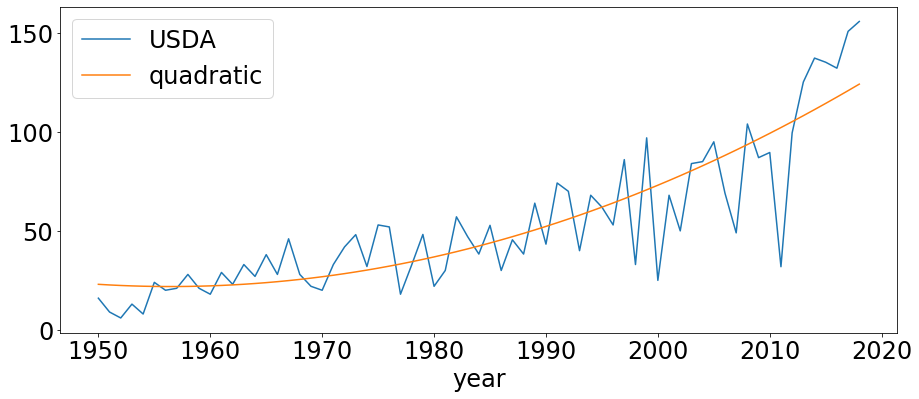

In [11]:
# Testing
fig, ax = plt.subplots(figsize = (15,6))
usda_county.query("GEOID == '106340'").reset_index().plot(x = "year", y = "Value", ax = ax, label = "USDA")
usda_county.query("GEOID == '106340'").reset_index().plot(x = "year", y = "quad_fit_nolog", ax = ax, label = "quadratic")
plt.legend()
plt.show()

In [12]:
# Save
usda_county.query("Value > 0.0").to_csv("./final/USDA_county_yields_w_county_quad_trends.csv", index = False)